# Carbon dioxoide injection in aquifer
This example demonstrates a custom K-value compositional model for the
injection of CO2 into a saline aquifer. The physical model for flow of CO2 is
a realization of the description in [11th SPE Comparative Solutions
Project](https://spe.org/en/csp/). Simulation of CO2 can be challenging, and
we load the HYPRE package to improve performance.

In [1]:
using Jutul, JutulDarcy
using HYPRE
using GLMakie
nx = 100
nz = 50
Darcy, bar, kg, meter, day = si_units(:darcy, :bar, :kilogram, :meter, :day)

(9.86923266716013e-13, 100000.0, 1.0, 1.0, 86400.0)

## Set up a 2D aquifer model
We set up a Cartesian mesh that is then transformed into an unstructured mesh.
We can then modify the coordinates to create a domain with a undulating top
surface. CO2 will flow along the top surface and the topography of the top
surface has a large impact on where the CO2 migrates.

In [2]:
cart_dims = (nx, 1, nz)
physical_dims = (1000.0, 1.0, 50.0)
mesh = UnstructuredMesh(CartesianMesh(cart_dims, physical_dims))

points = mesh.node_points
for (i, pt) in enumerate(points)
    x, y, z = pt
    x_u = 2*π*x/1000.0
    w = 0.2
    dz = 0.05*x + 0.05*abs(x - 500.0)+ w*(30*sin(2.0*x_u) + 20*sin(5.0*x_u))
    points[i] = pt + [0, 0, dz]
end

## Find and plot cells intersected by a deviated injector well
We place a single injector well. This well was unfortunately not drilled
completely straight, so we cannot directly use `add_vertical_well` based on
logical indices. We instead define a matrix with three columns x, y, z that
lie on the well trajectory and use utilities from `Jutul` to find the cells
intersected by the trajectory.

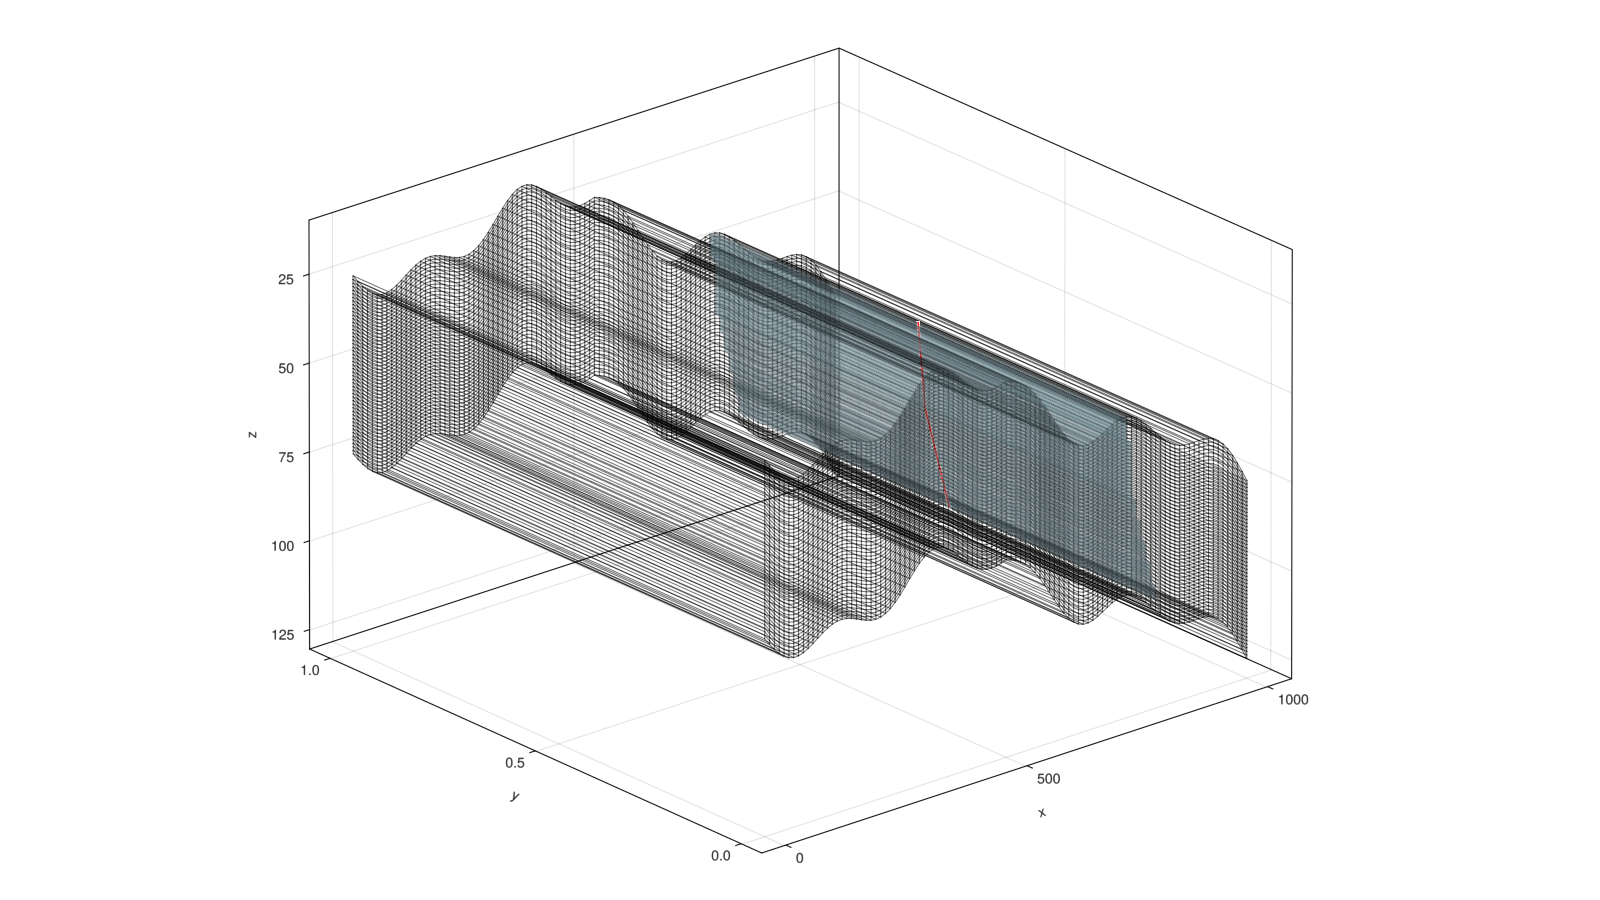

In [3]:
import Jutul: find_enclosing_cells, plot_mesh_edges
trajectory = [
    745.0 0.5 45;    # First point
    760.0 0.5 70;    # Second point
    810.0 0.5 100.0  # Third point
]

wc = find_enclosing_cells(mesh, trajectory)

fig, ax, plt = plot_mesh_edges(mesh, z_is_depth = true)
plot_mesh!(ax, mesh, cells = wc, transparency = true, alpha = 0.3)
lines!(ax, trajectory', color = :red)
fig

## Set up simulation model
We set up a domain and a single injector. We pass the special :co2brine
argument in place of the system to the reservoir model setup routine. This
will automatically set up a compositional two-component CO2-H2O model with the
appropriate functions for density, viscosity and miscibility.

Note that this model by default is isothermal, but we still need to specify a
temperature when setting up the model. This is because the properties of CO2
strongly depend on temperature, even when thermal transport is not solved.

In [4]:
domain = reservoir_domain(mesh, permeability = 0.3Darcy, porosity = 0.3, temperature = convert_to_si(30.0, :Celsius))
Injector = setup_well(domain, wc, name = :Injector, simple_well = true)

model = setup_reservoir_model(domain, :co2brine, wells = Injector, extra_out = false);

## Customize model by adding relative permeability with hysteresis
We define three relative permeability functions: kro(so) for the brine/liquid
phase and krg(g) for both drainage and imbibition. Here we limit the
hysteresis to only the non-wetting gas phase, but either combination of
wetting or non-wetting hysteresis is supported.

Note that we import a few utilities from JutulDarcy that are not exported by
default since hysteresis falls under advanced functionality.

In [5]:
import JutulDarcy: table_to_relperm, add_relperm_parameters!, brooks_corey_relperm
so = range(0, 1, 10)
krog_t = so.^2
krog = PhaseRelativePermeability(so, krog_t, label = :og)

PhaseRelativePermeability for og:
  .k: Internal representation: Jutul.LinearInterpolant{Vector{Float64}, Vector{Float64}, Missing}([-1.0e-16, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777778, 0.8888888888888887, 1.0], [0.0, 0.012345679012345678, 0.04938271604938271, 0.1111111111111111, 0.19753086419753085, 0.308641975308642, 0.4444444444444444, 0.6049382716049383, 0.7901234567901234, 1.0], missing)
  Connate saturation = 0.0
  Critical saturation = 0.0
  Maximum rel. perm = 1.0 at 1.0


Higher resolution for second table

In [6]:
sg = range(0, 1, 50)

0.0:0.02040816326530612:1.0

Evaluate Brooks-Corey to generate tables

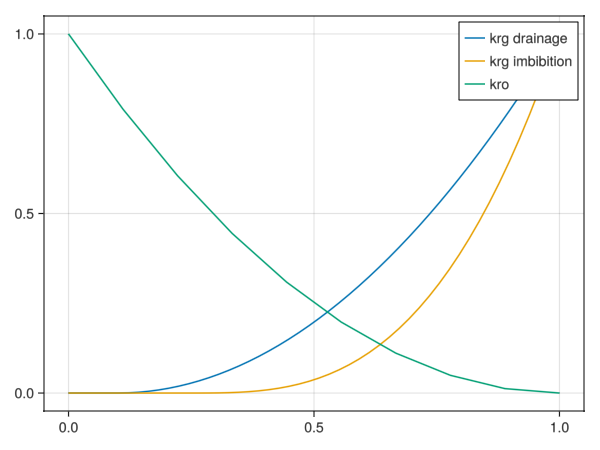

In [7]:
tab_krg_drain = brooks_corey_relperm.(sg, n = 2, residual = 0.1)
tab_krg_imb = brooks_corey_relperm.(sg, n = 3, residual = 0.25)

krg_drain  = PhaseRelativePermeability(sg, tab_krg_drain, label = :g)
krg_imb  = PhaseRelativePermeability(sg, tab_krg_imb, label = :g)

fig, ax, plt = lines(sg, tab_krg_drain, label = "krg drainage")
lines!(ax, sg, tab_krg_imb, label = "krg imbibition")
lines!(ax, 1 .- so, krog_t, label = "kro")
axislegend()
fig
# Define a relative permeability variable

JutulDarcy uses type instances to define how different variables inside the
simulation are evaluated. The `ReservoirRelativePermeabilities` type has
support for up to three phases with w, ow, og and g relative permeabilities
specified as a function of their respective phases. It also supports
saturation regions.

Note: If regions are used, all drainage curves come first followed by equal
number of imbibition curves. Since we only have a single (implicit) saturation
region, the krg input should have two entries: One for drainage, and one for
imbibition.

We also call `add_relperm_parameters` to the model. This makes sure that when
hysteresis is enabled, we track maximum saturation for hysteresis in each
reservoir cell.

In [8]:
import JutulDarcy: KilloughHysteresis, ReservoirRelativePermeabilities
krg = (krg_drain, krg_imb)
H_g = KilloughHysteresis() # Other options: CarlsonHysteresis, JargonHysteresis
relperm = ReservoirRelativePermeabilities(g = krg, og = krog, hysteresis_g = H_g)
replace_variables!(model, RelativePermeabilities = relperm)
add_relperm_parameters!(model)

MultiModel with 3 models and 3 cross-terms. 10003 equations, 10003 degrees of freedom and 39796 parameters.

  models:
    1) Reservoir (10000x10000)
       MultiPhaseCompositionalSystemLV (two-phase) with MultiComponentFlash.KValuesEOS EOS with 2 EOS components: H2O, CO2
       ∈ MinimalTPFATopology (5000 cells, 9850 faces)
    2) Injector (2x2)
       MultiPhaseCompositionalSystemLV (two-phase) with MultiComponentFlash.KValuesEOS EOS with 2 EOS components: H2O, CO2
       ∈ SimpleWell [Injector] (1 nodes, 0 segments, 47 perforations)
    3) Facility (1x1)
       JutulDarcy.PredictionMode()
       ∈ WellGroup([:Injector], true, true)

  cross_terms:
    1) Injector <-> Reservoir (Eq: mass_conservation)
       JutulDarcy.ReservoirFromWellFlowCT
    2) Injector  -> Facility (Eq: control_equation)
       JutulDarcy.FacilityFromWellFlowCT
    3) Facility  -> Injector (Eq: mass_conservation)
       JutulDarcy.WellFromFacilityFlowCT

Model storage will be optimized for runtime performance.


## Define approximate hydrostatic pressure
The initial pressure of the water-filled domain is assumed to be at
hydrostatic equilibrium.

In [9]:
nc = number_of_cells(mesh)
p0 = zeros(nc)
depth = domain[:cell_centroids][3, :]
g = Jutul.gravity_constant
@. p0 = 200bar + depth*g*1000.0

5000-element Vector{Float64}:
 2.0259817715480573e7
 2.027866256801526e7
 2.029561212648421e7
 2.030959379972497e7
 2.031980201350862e7
 2.03257681861333e7
 2.0327398227492694e7
 2.0324974022933237e7
 2.0319118878498632e7
 2.031073041981455e7
 ⋮
 2.1068522096501365e7
 2.1072473602066763e7
 2.1079856047507305e7
 2.1091292738866698e7
 2.1107065561491378e7
 2.1127080425275028e7
 2.1150868748515785e7
 2.1177624956984743e7
 2.1206276459519424e7

## Set up initial state and parameters

In [10]:
state0 = setup_reservoir_state(model,
    Pressure = p0,
    OverallMoleFractions = [1.0, 0.0],
)
parameters = setup_parameters(model)

Dict{Symbol, Any} with 3 entries:
  :Injector  => Dict{Symbol, Any}(:FluidVolume=>[0.0834249], :PerforationGravit…
  :Reservoir => Dict{Symbol, Any}(:Transmissibilities=>[2.85521e-14, 2.87444e-1…
  :Facility  => Dict{Symbol, Any}()

## Find the boundary and apply a constant pressureboundary condition
We find cells on the left and right boundary of the model and set a constant
pressure boundary condition to represent a bounding aquifer that retains the
initial pressure far away from injection.

In [11]:
boundary = Int[]
for cell in 1:nc
    I, J, K = cell_ijk(mesh, cell)
    if I == 1 || I == nx
        push!(boundary, cell)
    end
end
bc = flow_boundary_condition(boundary, domain, p0[boundary], fractional_flow = [1.0, 0.0])

100-element Vector{FlowBoundaryCondition{Int64, Float64, Tuple{Float64, Float64}}}:
 FlowBoundaryCondition{Int64, Float64, Tuple{Float64, Float64}}(1, 2.0259817715480573e7, 298.15, 1.4803849000740193e-12, 15.0, (1.0, 0.0), nothing)
 FlowBoundaryCondition{Int64, Float64, Tuple{Float64, Float64}}(100, 2.0725750609519426e7, 298.15, 1.4803849000740193e-12, 15.0, (1.0, 0.0), nothing)
 FlowBoundaryCondition{Int64, Float64, Tuple{Float64, Float64}}(101, 2.0269624365480576e7, 298.15, 1.4803849000740193e-12, 15.0, (1.0, 0.0), nothing)
 FlowBoundaryCondition{Int64, Float64, Tuple{Float64, Float64}}(200, 2.0735557259519424e7, 298.15, 1.4803849000740193e-12, 15.0, (1.0, 0.0), nothing)
 FlowBoundaryCondition{Int64, Float64, Tuple{Float64, Float64}}(201, 2.0279431015480574e7, 298.15, 1.4803849000740193e-12, 15.0, (1.0, 0.0), nothing)
 FlowBoundaryCondition{Int64, Float64, Tuple{Float64, Float64}}(300, 2.0745363909519427e7, 298.15, 1.4803849000740193e-12, 15.0, (1.0, 0.0), nothing)
 FlowBoundaryCondi

## Plot the model

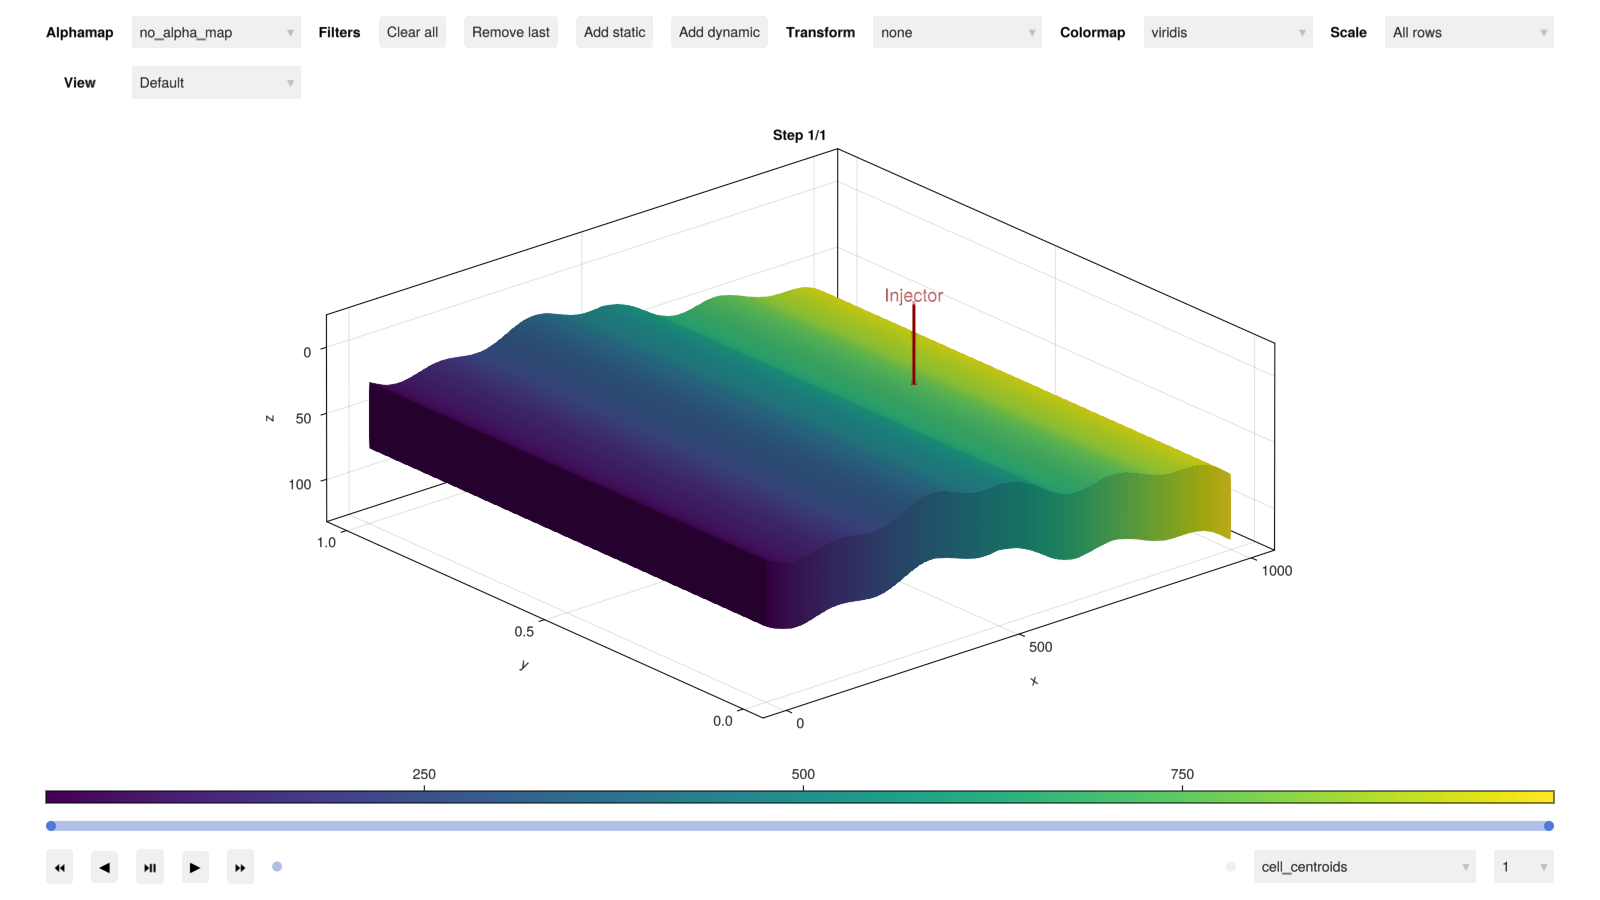

In [12]:
plot_reservoir(model)

## Set up schedule
We set up 25 years of injection and 25 years of migration where the well is
shut. The density of the injector is set to 900 kg/m^3, which is roughly
the density of CO2 at in-situ conditions.

In [13]:
nstep = 25
nstep_shut = 25
dt_inject = fill(365.0day, nstep)
pv = pore_volume(model, parameters)
inj_rate = 0.05*sum(pv)/sum(dt_inject)

rate_target = TotalRateTarget(inj_rate)
I_ctrl = InjectorControl(rate_target, [0.0, 1.0],
    density = 900.0,
)

InjectorControl{TotalRateTarget{Float64}, Float64, Tuple{Tuple{Int64, Float64}}, Vector{Float64}, Missing}(TotalRateTarget with value 9.512937595129376e-7 [m^3/s], [0.0, 1.0], 900.0, ((1, 1.0),), 293.15, missing, 1.0)

Set up forces for use in injection

In [14]:
controls = Dict(:Injector => I_ctrl)
forces_inject = setup_reservoir_forces(model, control = controls, bc = bc)

Dict{Symbol, Any} with 3 entries:
  :Injector  => (mask = nothing,)
  :Reservoir => (bc = FlowBoundaryCondition{Int64, Float64, Tuple{Float64, Floa…
  :Facility  => (control = Dict{Symbol, InjectorControl{TotalRateTarget{Float64…

Forces with shut wells

In [15]:
forces_shut = setup_reservoir_forces(model, bc = bc)
dt_shut = fill(365.0day, nstep_shut);

Combine the report steps and forces into vectors of equal length

In [16]:
dt = vcat(dt_inject, dt_shut)
forces = vcat(
    fill(forces_inject, nstep),
    fill(forces_shut, nstep_shut)
);

## Add some more outputs for plotting

In [17]:
rmodel = reservoir_model(model)
push!(rmodel.output_variables, :RelativePermeabilities)
push!(rmodel.output_variables, :PhaseViscosities)

9-element Vector{Symbol}:
 :Pressure
 :OverallMoleFractions
 :TotalMasses
 :LiquidMassFractions
 :VaporMassFractions
 :Saturations
 :PhaseMassDensities
 :RelativePermeabilities
 :PhaseViscosities

## Simulate the schedule
We set a maximum internal time-step of 30 days to ensure smooth convergence
and reduce numerical diffusion.

In [18]:
wd, states, t = simulate_reservoir(state0, model, dt,
    parameters = parameters,
    forces = forces,
    max_timestep = 90day
)

Simulating 49 years, 50.45 weeks as 50 report steps   4%  ETA: 0:04:04
  Progress:  Solving step 2/50 (4.00% of time interval complete)


Simulating 49 years, 50.45 weeks as 50 report steps   6%  ETA: 0:03:03
  Progress:  Solving step 3/50 (6.00% of time interval complete)


Simulating 49 years, 50.45 weeks as 50 report steps   8%  ETA: 0:02:22
  Progress:  Solving step 4/50 (8.00% of time interval complete)


Simulating 49 years, 50.45 weeks as 50 report steps  10%  ETA: 0:01:53
  Progress:  Solving step 5/50 (10.00% of time interval complete)


Simulating 49 years, 50.45 weeks as 50 report steps  12%  ETA: 0:01:35
  Progress:  Solving step 6/50 (12.00% of time interval complete)


Simulating 49 years, 50.45 weeks as 50 report steps  14%  ETA: 0:01:23
  Progress:  Solving step 7/50 (14.00% of time interval complete)


Simulating 49 years, 50.45 weeks as 50 report steps  16%  ETA: 0:01:14
  Progress:  Solving step 8/50 (16.00% of time interval complete)


Simulating 49 years, 50.45 wee

ReservoirSimResult with 50 entries:

  wells (1 present):
    :Injector
    Results per well:
       :H2O_mass_rate => Vector{Float64} of size (50,)
       :lrat => Vector{Float64} of size (50,)
       :orat => Vector{Float64} of size (50,)
       :control => Vector{Symbol} of size (50,)
       :bhp => Vector{Float64} of size (50,)
       :CO2_mass_rate => Vector{Float64} of size (50,)
       :mass_rate => Vector{Float64} of size (50,)
       :rate => Vector{Float64} of size (50,)
       :grat => Vector{Float64} of size (50,)

  states (Vector with 50 entries, reservoir variables for each state)
    :LiquidMassFractions => Matrix{Float64} of size (2, 5000)
    :PhaseMassDensities => Matrix{Float64} of size (2, 5000)
    :RelativePermeabilities => Matrix{Float64} of size (2, 5000)
    :OverallMoleFractions => Matrix{Float64} of size (2, 5000)
    :Saturations => Matrix{Float64} of size (2, 5000)
    :Pressure => Vector{Float64} of size (5000,)
    :VaporMassFractions => Matrix{Float64} 

## Plot the CO2 mole fraction
We plot log10 of the CO2 mole fraction. We use log10 to account for the fact
that the mole fraction in cells made up of only the aqueous phase is much
smaller than that of cells with only the gaseous phase, where there is almost
just CO2.

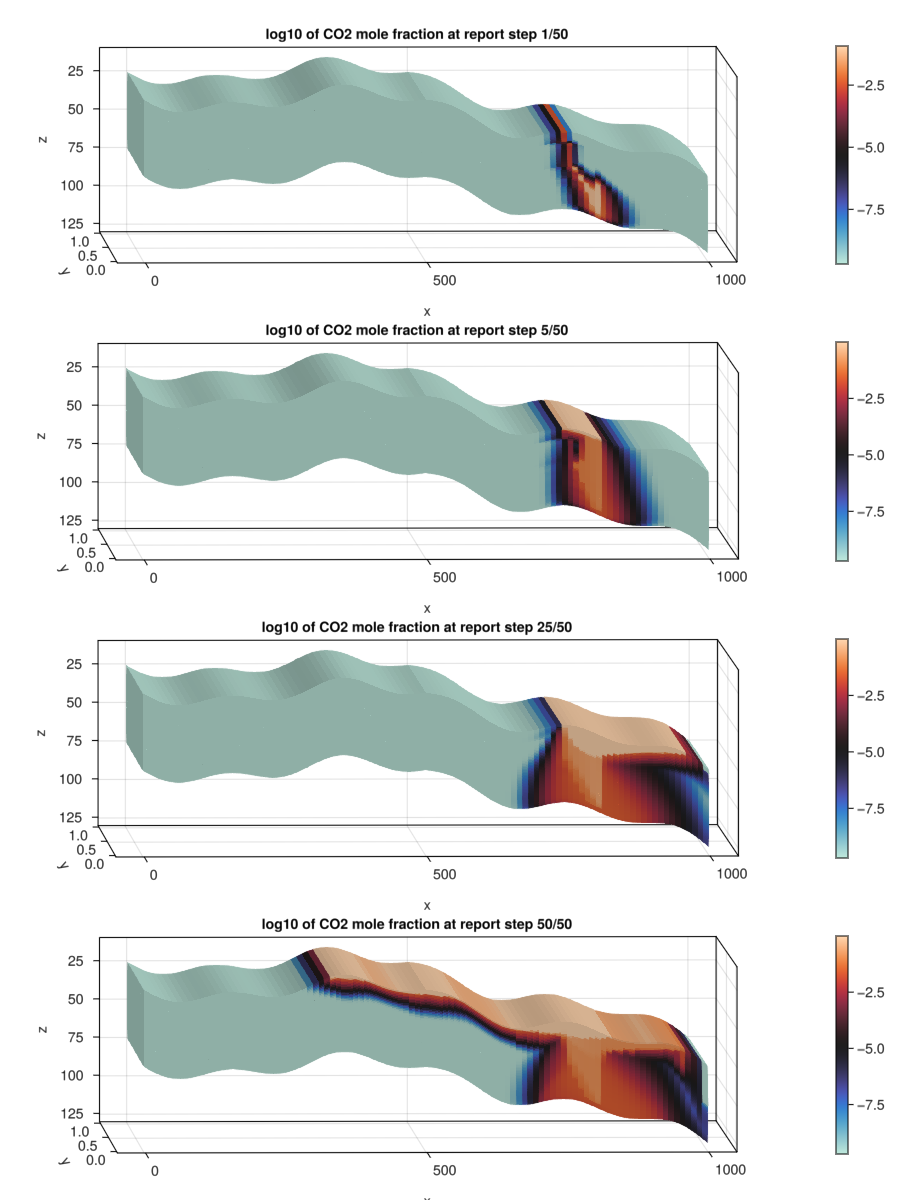

In [19]:
using GLMakie
function plot_co2!(fig, ix, x, title = "")
    ax = Axis3(fig[ix, 1],
        zreversed = true,
        azimuth = -0.51π,
        elevation = 0.05,
        aspect = (1.0, 1.0, 0.3),
        title = title)
    plt = plot_cell_data!(ax, mesh, x, colormap = :seaborn_icefire_gradient)
    Colorbar(fig[ix, 2], plt)
end
fig = Figure(size = (900, 1200))
for (i, step) in enumerate([1, 5, nstep, nstep+nstep_shut])
    plot_co2!(fig, i, log10.(states[step][:OverallMoleFractions][2, :]), "log10 of CO2 mole fraction at report step $step/$(nstep+nstep_shut)")
end
fig

## Plot all relative permeabilities for all time-steps
We can plot all relative permeability evaluations. This both verifies that the
hysteresis model is active, but also gives an indication to how many cells are
exhibiting imbibition during the simulation.

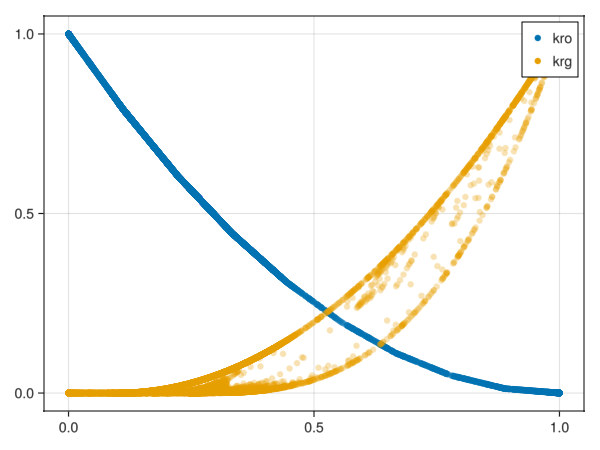

In [20]:
kro_val = Float64[]
krg_val = Float64[]
sg_val = Float64[]
for state in states
    kr_state = state[:RelativePermeabilities]
    s_state = state[:Saturations]
    for c in 1:nc
        push!(kro_val, kr_state[1, c])
        push!(krg_val, kr_state[2, c])
        push!(sg_val, s_state[2, c])
    end
end

fig = Figure()
ax = Axis(fig[1, 1], title = "Relative permeability during simulation")
fig, ax, plt = scatter(sg_val, kro_val, label = "kro", alpha = 0.3)
scatter!(ax, sg_val, krg_val, label = "krg", alpha = 0.3)
axislegend()
fig

## Plot result in interactive viewer
If you have interactive plotting available, you can explore the results
yourself.

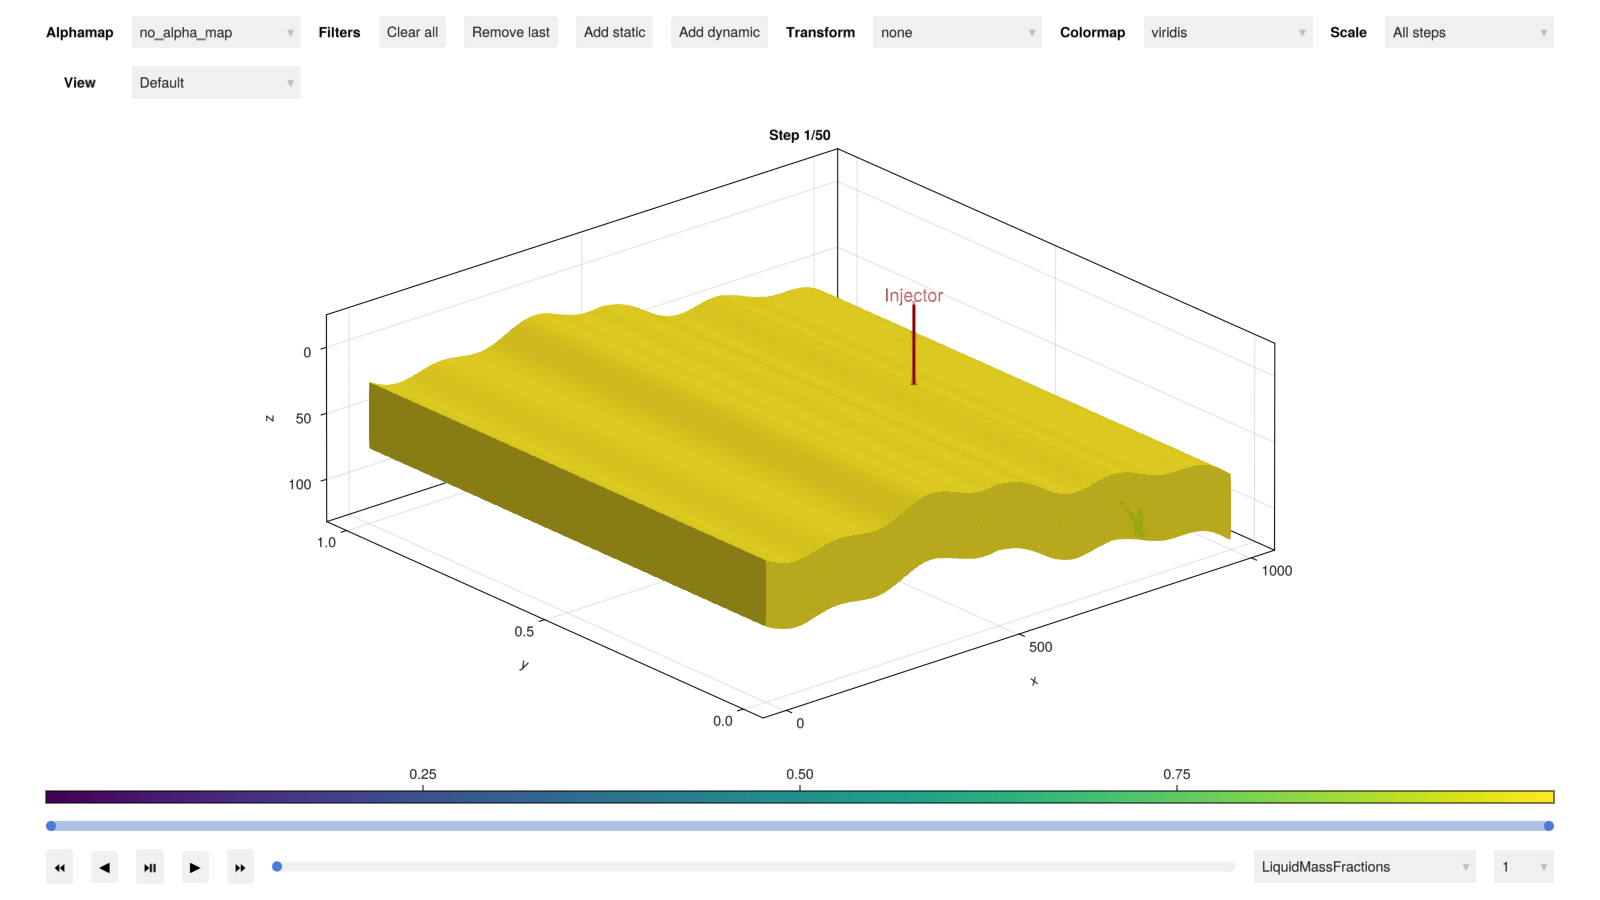

In [21]:
plot_reservoir(model, states)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*